In [1]:
from ROOT import TFile,vector
import ROOT
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import numpy as np
from numpy import mean
from math import sqrt,acos,cos,sin,pi,exp,log,isnan,atan2
from numpy import asarray
from root_pandas import read_root
from matplotlib import gridspec
from scipy import stats
import seaborn as sns

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from numpy import asarray

from scipy import stats
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from textwrap import wrap
import seaborn as sns

import os

from PlottingScripts import CV, Spline, Tune1, sampHist, distVar,distplot_wratio,StackedHisto,SimpleHisto

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Welcome to JupyROOT 6.18/04


This notebook facilitates the easy training of BDTs and testing of their quality

In [2]:
datafolder = '../../data'
dumpfolder = '../PlotDumps'

## Load  Things Up

In [3]:
#wc tagger
NUMU_RUN1_POT = 4.71579e+20
NUMU_LOWE_RUN1_POT = 1.63103516179e+21
NUE_RUN1_POT  = 9.80259e+22
RUN1_POT = 4.403e+19   #  run1
EXTRUN1_POT = (22474918.0) / float ( 9776965.0) * RUN1_POT #run1
DIRT_RUN1_POT = 2.61947e+20

NUMU_RUN3_POT = 8.98773223801e+20
NUMU_LOWE_RUN3_POT = 1.51234621011e+21
NUE_RUN3_POT = 4.70704675581e+22
RUN3_POT = 8.786e+18 # no beam quality  cut
#RUN3_POT = 1.701e+20 #1.5e20
EXTRUN3_POT = (39566274.0) / float (2263559) * RUN3_POT
#EXTRUN3_POT = (39566274.0) / float (43980680.0) * RUN3_POT


POT_SCALE_FACTOR = RUN1_POT
NUMU_RUN1_SCALE = POT_SCALE_FACTOR / float(NUMU_RUN1_POT)
NUMU_LOWE_RUN1_SCALE = POT_SCALE_FACTOR / float(NUMU_LOWE_RUN1_POT)
NUMU_RUN3_SCALE = POT_SCALE_FACTOR / float(NUMU_RUN3_POT)
NUMU_LOWE_RUN3_SCALE = POT_SCALE_FACTOR / float(NUMU_LOWE_RUN3_POT)
NUE_RUN1_SCALE = POT_SCALE_FACTOR / float(NUE_RUN1_POT)
NUE_RUN3_SCALE = POT_SCALE_FACTOR / float(NUE_RUN3_POT)
EXT_RUN1_SCALE = POT_SCALE_FACTOR / float(EXTRUN1_POT)
EXT_RUN3_SCALE = POT_SCALE_FACTOR / float(EXTRUN3_POT)
DIRT_RUN1_SCALE = POT_SCALE_FACTOR / float(DIRT_RUN1_POT)


RUN1_SCALE = POT_SCALE_FACTOR / float(RUN1_POT)
RUN3_SCALE = POT_SCALE_FACTOR / float(RUN3_POT)

print(RUN3_POT)

8.786e+18


In [4]:
tag = 'May1'

orthogonalcut = 'MaxShrFrac < .2'
precuts ='OpenAng > .5 and ChargeNearTrunk > 0 and FailedBoost != 1'
emptycut = 'Enu_1m1p > 0'

precut = orthogonalcut + ' and ' + precuts

df_numu_run1_presel = pd.read_parquet('../../data/pickles/ood/numu_run1_nodupes%s.parquet'%tag).query(precut)
df_numu_run1_presel_lowe = pd.read_parquet('../../data/pickles/ood/numu_lowe_run1_nodupes%s.parquet'%tag).query(precut)

df_numu_run3_presel = pd.read_parquet('../../data/pickles/ood/numu_run3_nodupes%s.parquet'%tag).query(precut)
df_numu_run3_presel_lowe = pd.read_parquet('../../data/pickles/ood/numu_lowe_run3_nodupes%s.parquet'%tag).query(precut)

df_nue_run1_presel = pd.read_parquet('../../data/pickles/ood/nue_run1_nodupes%s.parquet'%tag).query(precut)
df_nue_run3_presel = pd.read_parquet('../../data/pickles/ood/nue_run3_nodupes%s.parquet'%tag).query(precut)

df_ext_run1_presel = pd.read_parquet('../../data/pickles/ood/ext_run1_nodupes%s.parquet'%tag).query(precut)
df_ext_run3_presel = pd.read_parquet('../../data/pickles/ood/ext_run3_nodupes%s.parquet'%tag).query(precut)

df_data_run1_presel = pd.read_parquet('../../data/pickles/ood/data_run1_nodupes%s.parquet'%tag).query(precut)
df_data_run3_presel = pd.read_parquet('../../data/pickles/ood/data_run3_filter_nodupes%s.parquet'%tag).query(precut)

df_dirt_run1_presel = pd.read_parquet('../../data/pickles/ood/dirt_run1_nodupes%s.parquet'%tag).query(precut)


## This is where the magic happens

In [5]:
nbins = 45
s_annotation = 'All Precuts, Orthogonality Cuts'

#run1
df_numu_presel_r1 = pd.concat((df_numu_run1_presel,df_numu_run1_presel_lowe))
df_ccqe_r1 = df_numu_run1_presel.query("mc_label in ['numu_CCQE']")
df_ccqe_lowe_r1 = df_numu_run1_presel_lowe.query("mc_label in ['numu_CCQE']")

df_cosmic_r1 = pd.concat([df_ext_run1_presel,df_numu_presel_r1.query("mc_label in ['offvtx']")],sort=False)
df_nubkg_r1 = df_numu_presel_r1.query("mc_label not in ['numu_CCQE','nLmP','offvtx']")
#df_nlmp_r1 = df_numu_presel_r1.query("mc_label in ['nLmP'] and int_label not in ['numu_CCQE']")


# #run2
# df_ccqe_r2 = df_numu_run2_presel.query("mc_label in ['numu_CCQE']")

# df_cosmic_r2 = pd.concat([df_ext_run3_presel,df_numu_run2_presel.query("mc_label in ['offvtx']")],sort=False)
# df_nubkg_r2 = df_numu_run2_presel.query("mc_label not in ['numu_CCQE','nLmP','offvtx']")
# #df_nlmp_r2 = df_numu_run2_presel.query("mc_label in ['nLmP'] and int_label not in ['numu_CCQE']")


#run3
df_numu_presel_r3 = pd.concat((df_numu_run3_presel,df_numu_run3_presel_lowe))
df_ccqe_r3 = df_numu_run3_presel.query("mc_label in ['numu_CCQE']")
df_ccqe_lowe_r3 = df_numu_run3_presel_lowe.query("mc_label in ['numu_CCQE']")

df_cosmic_r3 = pd.concat([df_ext_run3_presel,df_numu_presel_r3.query("mc_label in ['offvtx']")],sort=False)
df_nubkg_r3 = df_numu_presel_r3.query("mc_label not in ['numu_CCQE','nLmP','offvtx']")
#df_nlmp_r3 = df_numu_presel_r3.query("mc_label in ['nLmP'] and int_label not in ['numu_CCQE']")

In [20]:
# ok. let's  print out training sample so we can excise them later

X = df_signal[['run','subrun']].values.tolist()
Y_bkg = pd.concat((df_extbkg,df_nubkg),sort=False)[['run','subrun']].values.tolist()

#######################################################################################################
Xl = [1 for i in range(len(X))]
Yl = [0 for i in range(len(Y_bkg))]

seed = 15
test_size = 0.7
x_train, x_test, y_train, y_test = train_test_split(asarray(X+Y_bkg), asarray(Xl+Yl), test_size=test_size, random_state=seed)

#df_me = pd.DataFrame(x_train,columns=['run','subrun','event','vtxid'])

# Weight the bdts

In [6]:
#vars_cos_allofem = ['Eta','ChargeNearTrunk','PT_1m1p','PhiT_1m1p','AlphaT_1m1p','Sph_1m1p','Q0_1m1p','Q2_1m1p','Q3_1m1p','Lepton_ThetaReco','Lepton_PhiReco','Proton_ThetaReco','Proton_PhiReco','PTRat_1m1p','Lepton_TrackLength','Thetas','Phis','Proton_TrackLength','OpenAng','PzEnu_1m1p']
#vars_apr14 = ['Eta','ChargeNearTrunk','PT_1m1p','PhiT_1m1p','AlphaT_1m1p','Sph_1m1p','Q0_1m1p','Q2_1m1p','Q3_1m1p','Lepton_ThetaReco','Lepton_PhiReco','Proton_ThetaReco','Proton_PhiReco','PTRat_1m1p','Lepton_TrackLength','Thetas','Phis','Proton_TrackLength','OpenAng','PzEnu_1m1p','BjX_1m1p','BjY_1m1p']
#vars_may7 = ['Proton_Edep','Muon_Edep','OpenAng','Enu_1m1p','CCQEEnergyShift_1m1p','ChargeNearTrunk','PT_1m1p','PhiT_1m1p','AlphaT_1m1p','Sph_1m1p','Q0_1m1p','Q3_1m1p','Lepton_PhiReco','Proton_ThetaReco','Proton_PhiReco','PTRat_1m1p','Phis','BjX_1m1p','BjY_1m1p']
#vars_may13 = ['OpenAng','Phis','ChargeNearTrunk','Enu_1m1p','PhiT_1m1p','AlphaT_1m1p','PT_1m1p','PTRat_1m1p','BjX_1m1p','BjY_1m1p','Sph_1m1p','Q0_1m1p','Q3_1m1p','Lepton_PhiReco','Lepton_TrackLength','Proton_PhiReco','Proton_ThetaReco']
#vars_june1_kinematic = ['Phis','PTRat_1m1p','Lepton_PhiReco','Lepton_TrackLength','Proton_PhiReco','Proton_ThetaReco']
#vars_june1_other = ['ChargeNearTrunk','Enu_1m1p','PhiT_1m1p','AlphaT_1m1p','PT_1m1p','BjXB_1m1p','BjYB_1m1p','SphB_1m1p','Q0_1m1p','Q3_1m1p']

vars_june1 = ['Phis','ChargeNearTrunk','Enu_1m1p','PhiT_1m1p','AlphaT_1m1p','PT_1m1p','PTRat_1m1p','BjXB_1m1p','BjYB_1m1p','SphB_1m1p','Q0_1m1p','Q3_1m1p','Lepton_PhiReco','Lepton_TrackLength','Proton_PhiReco','Proton_ThetaReco']
RSEE = ['run','subrun','event','vtxid']

myvars = vars_june1

## To exactly reproduce Neutrino 2020 BDT Weights ( June 1st Tag)

In [45]:
# set below to either run 1 or 3
df_ccqe = df_ccqe_r1
df_ccqe_lowe = df_ccqe_lowe_r1
df_cosmic = df_cosmic_r1
df_nubkg = df_nubkg_r1

X = pd.concat((df_ccqe,df_ccqe_lowe),sort=False)[myvars].values.tolist()
w1 = np.ones(len(df_ccqe))*1.0
w2 = np.ones(len(df_ccqe_lowe))*1
wsig = np.concatenate((w1,w2))

Y_bkg = pd.concat((df_cosmic,df_nubkg),sort=False)[myvars].values.tolist()
wbkg = np.ones(len(Y_bkg))

Xl = [1 for i in range(len(X))]
Yl = [0 for i in range(len(Y_bkg))]

seed = 15
test_size = 0.7
x_train, x_test, y_train, y_test, w_train, w_test = train_test_split(asarray(X+Y_bkg), asarray(Xl+Yl), np.concatenate((wsig,wbkg)), test_size=test_size, random_state=seed)

In [46]:
eval_set = [(x_train, y_train), (x_test, y_test)]
eval_metric = ['logloss','error']
bkgBDT = XGBClassifier(silent=False, 
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = .8,
                      objective='binary:logistic',
                      subsample = 0.8, 
                      n_estimators=1000, 
                      max_depth=5, 
                      gamma=5)


bkgBDT.fit(x_train, y_train, eval_metric=eval_metric, eval_set=eval_set,verbose=False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=5,
              learning_rate=0.01, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=False, subsample=0.8, verbosity=1)

In [47]:
y_checkV = bkgBDT.predict(x_test) #
y_checkT = bkgBDT.predict(x_train) #
#
predictionsV = [round(value) for value in y_checkV] #
predictionsT = [round(value) for value in y_checkT] #
accuracy_diff = (accuracy_score(y_test, predictionsV)-accuracy_score(y_train,predictionsT))*100. #


acc_test = accuracy_score(y_test, predictionsV)
acc_train = accuracy_score(y_train,predictionsT)
accuracy_diff = (acc_test-acc_train)*100. #
print("Accuracy Test:  ",acc_test)
print("Accuracy Train: ",acc_train)
print("TestAcc - TrainAcc = ",accuracy_diff)

Accuracy Test:   0.8662544468914112
Accuracy Train:  0.9088752717928444
TestAcc - TrainAcc =  -4.262082490143326


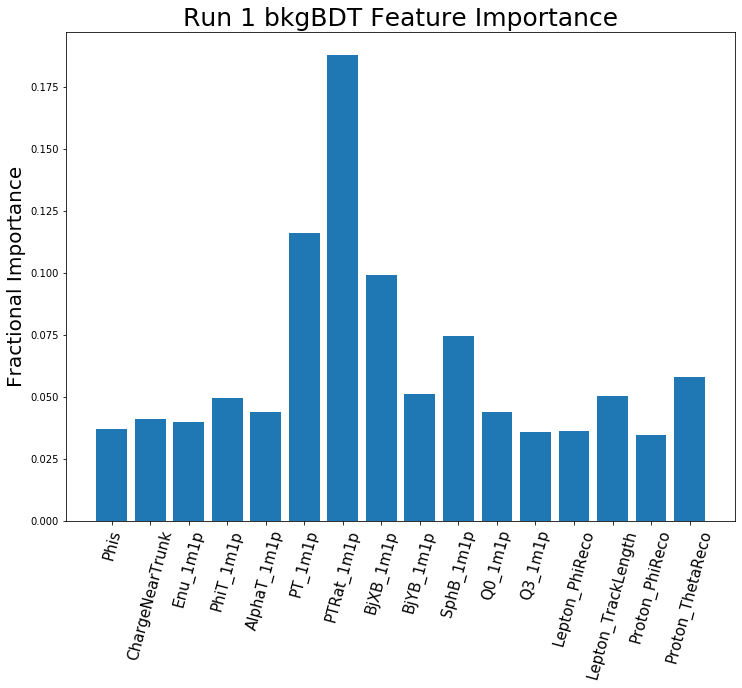

In [49]:
fig,ax = plt.subplots(figsize=(12,9))
ax.set_title('Run 1 bkgBDT Feature Importance',fontsize=25)
ax.set_ylabel('Fractional Importance',fontsize=20)
plt.bar(range(len(bkgBDT.feature_importances_)), bkgBDT.feature_importances_)
plt.xticks(range(len(bkgBDT.feature_importances_)),myvars, rotation=75,fontsize=15)
plt.show()



Left of .4
CCQE: 0.586
CCQE lowe: 0.396
CosBkg: 0.012
NuBkg Badreco: 0.064
NuBkg Other: 0.100


Text(0.05, 0.3, 'NuBkg Other: 10.0%')

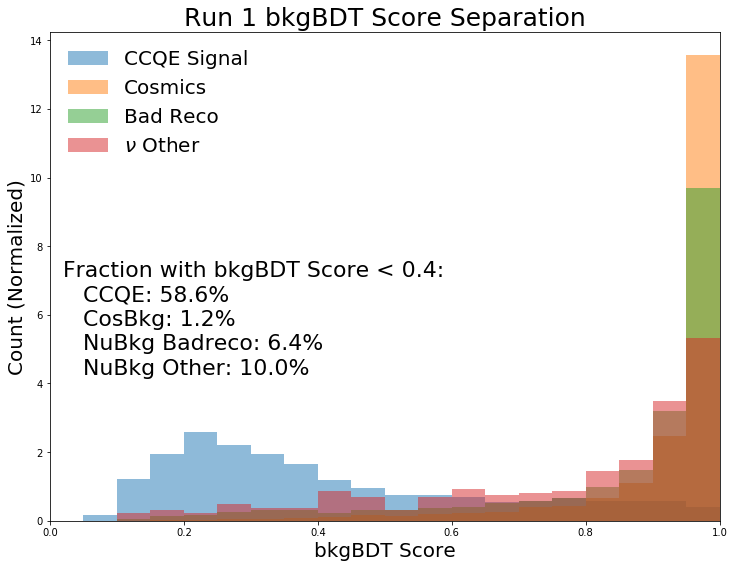

In [50]:
fig,ax = plt.subplots(figsize=(12,9))
ax.set_ylabel('Count (Normalized)',fontsize=20)
ax.set_xlabel('bkgBDT Score',fontsize=20)
ax.set_xlim(0,1)
ax.set_title('Run 1 bkgBDT Score Separation',fontsize=25)

bdt_score_ccqe = bkgBDT.predict_proba(df_ccqe_r1[myvars].values.tolist())
bdt_score_ccqe_lowe = bkgBDT.predict_proba(df_ccqe_lowe_r1[myvars].values.tolist())
bdt_score_cosbkg = bkgBDT.predict_proba(df_cosmic_r1[myvars].values.tolist())
bdt_score_nubkg_badreco = bkgBDT.predict_proba(df_nubkg_r1.query("mc_label in ['badreco']")[myvars].values.tolist())
bdt_score_nubkg_other = bkgBDT.predict_proba(df_nubkg_r1.query("mc_label not in ['badreco']")[myvars].values.tolist())
#bdt_score_nlmp = bkgBDT.predict_proba(df_nlmp_r1[myvars].values.tolist())


hccqe,_ = np.histogram(bdt_score_ccqe[:,0],10,(0,1))
hccqelowe,_ = np.histogram(bdt_score_ccqe_lowe[:,0],10,(0,1))
hcos,_ = np.histogram(bdt_score_cosbkg[:,0],10,(0,1))
hnu_badreco,_ = np.histogram(bdt_score_nubkg_badreco[:,0],10,(0,1))
hnu_other,_ = np.histogram(bdt_score_nubkg_other[:,0],10,(0,1))
#hnlmp,_ = np.histogram(bdt_score_nlmp[:,0],10,(0,1))

print('Left of .4')
ccqe_eff = hccqe[:4].sum()/float(hccqe.sum())
print('CCQE: %.3f'%(ccqe_eff))
print('CCQE lowe: %.3f'%(hccqelowe[:4].sum()/float(hccqelowe.sum())))
cosmics_eff = hcos[:4].sum()/float(hcos.sum())
print('CosBkg: %.3f'%(cosmics_eff))
badreco_eff = hnu_badreco[:4].sum()/float(hnu_badreco.sum())
print('NuBkg Badreco: %.3f'%(badreco_eff))
other_eff = hnu_other[:4].sum()/float(hnu_other.sum())
print('NuBkg Other: %.3f'%(other_eff))
#print('nLmP: %.3f'%(hnlmp[:4].sum()/float(hnlmp.sum())))

_ = plt.hist(bdt_score_ccqe[:,0],20,(0,1),alpha = .5,density=1,label='CCQE Signal')
_ = plt.hist(bdt_score_cosbkg[:,0],20,(0,1),alpha = .5,density=1,label='Cosmics')
_ = plt.hist(bdt_score_nubkg_badreco[:,0],20,(0,1),alpha = .5,density=1,label='Bad Reco')
_ = plt.hist(bdt_score_nubkg_other[:,0],20,(0,1),alpha = .5,density=1,label=r'$\nu$ Other')

ax.legend(fontsize=20,frameon=False)

#left of .4
# 60% CCQE signal efficiency
# 55% CCQE lowE (<400MeV) signal efficiency
# 1% Cosmic Background efficiency
# 5% Nu Background efficiency
# 2% Non 1L1P efficiency


ax.annotate('Fraction with bkgBDT Score < 0.4:',xy=(.02,.5), xycoords='axes fraction',fontsize=22)
ax.annotate('CCQE: %.1f'%(ccqe_eff*100)+'%',xy=(.05,.45), xycoords='axes fraction',fontsize=22)
ax.annotate('CosBkg: %.1f'%(cosmics_eff*100)+'%',xy=(.05,.4), xycoords='axes fraction',fontsize=22)
ax.annotate('NuBkg Badreco: %.1f'%(badreco_eff*100)+'%',xy=(.05,.35), xycoords='axes fraction',fontsize=22)
ax.annotate('NuBkg Other: %.1f'%(other_eff*100)+'%',xy=(.05,.3), xycoords='axes fraction',fontsize=22)


#  Unused attempts at improving the BDT after the fact
ie: when it was too late to change anything. Here's what I would have done differently.

In [7]:
df_ccqe = df_ccqe_r3
df_ccqe_lowe = df_ccqe_lowe_r3
df_cosmic = df_cosmic_r3
df_nubkg = df_nubkg_r3

X = pd.concat((df_ccqe,df_ccqe_lowe),sort=False)[myvars].values.tolist()
w1 = np.ones(len(df_ccqe))*1.0
w2 = np.ones(len(df_ccqe_lowe))*1
wsig = np.concatenate((w1,w2))

Y_bkg = pd.concat((df_cosmic,df_nubkg),sort=False)[myvars].values.tolist()
wbkg = np.ones(len(Y_bkg))

In [8]:
Xl = [1 for i in range(len(X))]
Yl = [0 for i in range(len(Y_bkg))]

seed = 15
test_size = 0.7
x_train, x_test, y_train, y_test, w_train, w_test = train_test_split(asarray(X+Y_bkg), asarray(Xl+Yl), np.concatenate((wsig,wbkg)), test_size=test_size, random_state=seed)

In [ ]:
# Define signal and background for training.

nbins = 45
s_annotation = 'All Precuts, Orthogonality Cuts'

#run1
df_numu_presel = pd.concat((df_numu_run1_presel,df_numu_run1_presel_lowe))
df_signal = df_numu_presel.query("mc_label in ['numu_CCQE']")
df_extbkg = pd.concat([df_ext_run1_presel,df_dirt_run1_presel,df_numu_presel.query("mc_label in ['offvtx','nLmP','badreco']")],sort=False)
df_nubkg = df_numu_presely.query("mc_label not in ['numu_CCQE']")

#run3
#df_numu_presel = pd.concat((df_numu_run3_presel,df_numu_run3_presel_lowe,df_nue_run3_presel))
#df_signal = df_numu_presel.query("mc_label in ['numu_CCQE']")
#df_extbkg = pd.concat([df_ext_run3_presel,df_numu_presel.query("mc_label in ['offvtx','nLmP','badreco']")],sort=False)
#df_nubkg = df_numu_presel.query("mc_label not in ['numu_CCQE']")

In [43]:
print(y_train)

[0 1 0 ... 1 0 0]


Text(0, 0.5, 'logloss')

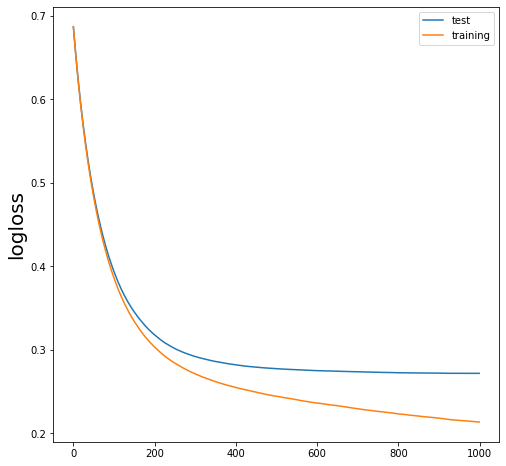

In [13]:
#######################################################################################################
Xl = [1 for i in range(len(X))]
Yl = [0 for i in range(len(Y_bkg))]

seed = 15
test_size = 0.7
x_train, x_test, y_train, y_test, w_train, w_test = train_test_split(asarray(X+Y_bkg), asarray(Xl+Yl), np.concatenate((wsig,wbkg)), test_size=test_size, random_state=seed)

eval_set = [(x_train, y_train), (x_test, y_test)]
eval_metric = ['logloss','error']
bkgBDT = XGBClassifier(silent=False, 
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      #colsample_bytree = .8,
                      objective='binary:logistic',
                      subsample = 0.8, 
                      n_estimators=1000, 
                      max_depth=5, 
                      gamma=5)


bkgBDT.fit(x_train, y_train, sample_weight=w_train,eval_metric=eval_metric, eval_set=eval_set,verbose=False)

quant='logloss'
y_training = bkgBDT.evals_result()['validation_0'][quant]
y_testing = bkgBDT.evals_result()['validation_1'][quant]

fig,ax = plt.subplots(figsize=(8,8))
plt.plot(range(len(y_testing)),y_testing,label='test')
plt.plot(range(len(y_testing)),y_training,label='training')
ax.legend()
ax.set_ylabel(quant,fontsize=20)

Text(0, 0.5, 'logloss')

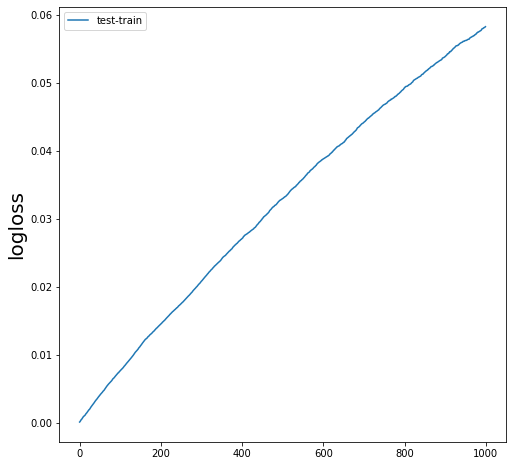

In [14]:
fig,ax = plt.subplots(figsize=(8,8))
plt.plot(range(len(y_testing)),np.asarray(y_testing)-np.asarray(y_training),label='test-train')
ax.legend()
ax.set_ylabel(quant,fontsize=20)

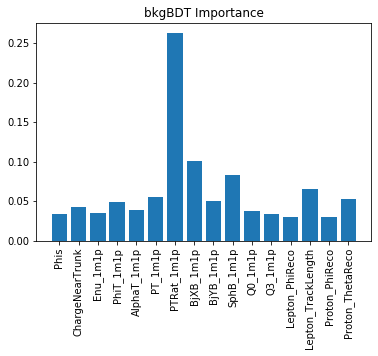

Accuracy Test:   0.8827070331518612
Accuracy Train:  0.9087998347448875
TestAcc - TrainAcc =  -2.6092801593026294


In [15]:
y_checkV = bkgBDT.predict(x_test) #
y_checkT = bkgBDT.predict(x_train) #
#
predictionsV = [round(value) for value in y_checkV] #
predictionsT = [round(value) for value in y_checkT] #
accuracy_diff = (accuracy_score(y_test, predictionsV)-accuracy_score(y_train,predictionsT))*100. #

fig,ax = plt.subplots(figsize=(6,4))
ax.set_title('bkgBDT Importance')
plt.bar(range(len(bkgBDT.feature_importances_)), bkgBDT.feature_importances_)
plt.xticks(range(len(bkgBDT.feature_importances_)),myvars, rotation='vertical')
plt.show()

acc_test = accuracy_score(y_test, predictionsV)
acc_train = accuracy_score(y_train,predictionsT)
accuracy_diff = (acc_test-acc_train)*100. #
print("Accuracy Test:  ",acc_test)
print("Accuracy Train: ",acc_train)
print("TestAcc - TrainAcc = ",accuracy_diff)

Left of .4
CCQE: 0.533
CCQE lowe: 0.185
CosBkg: 0.007
NuBkg Badreco: 0.065
NuBkg Other: 0.132
nLmP: 0.013


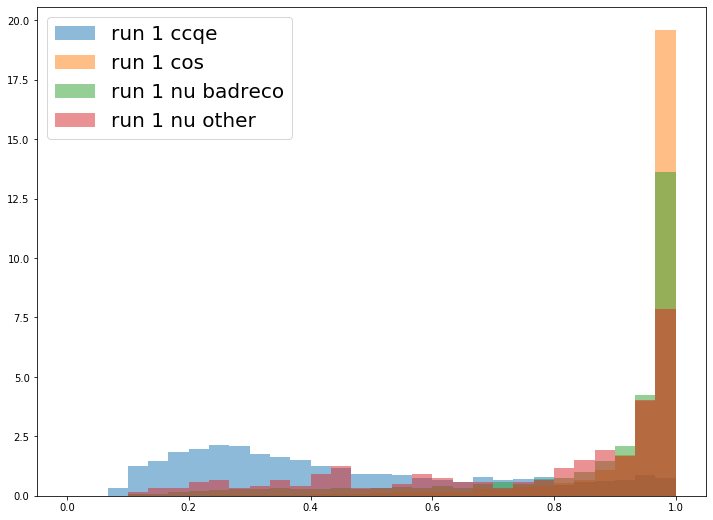

In [17]:
fig,ax = plt.subplots(figsize=(12,9))

bdt_score_ccqe = bkgBDT.predict_proba(df_ccqe_r1[myvars].values.tolist())
bdt_score_ccqe_lowe = bkgBDT.predict_proba(df_ccqe_lowe_r1[myvars].values.tolist())
bdt_score_cosbkg = bkgBDT.predict_proba(df_cosmic_r1[myvars].values.tolist())
bdt_score_nubkg_badreco = bkgBDT.predict_proba(df_nubkg_r1.query("mc_label in ['badreco']")[myvars].values.tolist())
bdt_score_nubkg_other = bkgBDT.predict_proba(df_nubkg_r1.query("mc_label not in ['badreco']")[myvars].values.tolist())
bdt_score_nlmp = bkgBDT.predict_proba(df_nlmp_r1[myvars].values.tolist())


hccqe,_ = np.histogram(bdt_score_ccqe[:,0],10,(0,1))
hccqelowe,_ = np.histogram(bdt_score_ccqe_lowe[:,0],10,(0,1))
hcos,_ = np.histogram(bdt_score_cosbkg[:,0],10,(0,1))
hnu_badreco,_ = np.histogram(bdt_score_nubkg_badreco[:,0],10,(0,1))
hnu_other,_ = np.histogram(bdt_score_nubkg_other[:,0],10,(0,1))
hnlmp,_ = np.histogram(bdt_score_nlmp[:,0],10,(0,1))

print('Left of .4')
print('CCQE: %.3f'%(hccqe[:4].sum()/float(hccqe.sum())))
print('CCQE lowe: %.3f'%(hccqelowe[:4].sum()/float(hccqelowe.sum())))
print('CosBkg: %.3f'%(hcos[:4].sum()/float(hcos.sum())))
print('NuBkg Badreco: %.3f'%(hnu_badreco[:4].sum()/float(hnu_badreco.sum())))
print('NuBkg Other: %.3f'%(hnu_other[:4].sum()/float(hnu_other.sum())))
print('nLmP: %.3f'%(hnlmp[:4].sum()/float(hnlmp.sum())))


_ = plt.hist(bdt_score_ccqe[:,0],30,(0,1),alpha = .5,density=1,label='run 1 ccqe')
_ = plt.hist(bdt_score_cosbkg[:,0],30,(0,1),alpha = .5,density=1,label='run 1 cos')
_ = plt.hist(bdt_score_nubkg_badreco[:,0],30,(0,1),alpha = .5,density=1,label='run 1 nu badreco')
_ = plt.hist(bdt_score_nubkg_other[:,0],30,(0,1),alpha = .5,density=1,label='run 1 nu other')

ax.legend(fontsize=20)

#Left of .5
#CCQE: 0.704
#CCQE lowe: 0.546
#CosBkg: 0.022
#uBkg: 0.080
#nLmP: 0.043

In [145]:
pickle.dump(bkgBDT,open( "../../1mu1pSelection/bdtweight_series3_aug26_run3.pickle", "wb" ),protocol=2)

## experimental zone

nothing below this point is considered up-to-date; but is kept for historical record

In [ ]:
#thiscut  = 'Thetas < 3 and abs(sin(Lepton_PhiReco)) < .8'
fancycut = 'PTRat_1m1p < -(Thetas - 1.5)/3 + 1 and Thetas < 3'
emptycut = 'OpenAng >= 0 and Thetas > 2'
thiscut = emptycut

var1 = 'LongTrackLen'
var2 = 'Phis'
ext_var1 = df_ext_presel.query(thiscut)[var1].values
ext_var2 = df_ext_presel.query(thiscut)[var2].values

numu_var1 = df_numu_presel.query('scedr_corrected <  5 and '+thiscut)[var1].values
numu_var2 = df_numu_presel.query('scedr_corrected <  5 and '+thiscut)[var2].values

fig,ax = plt.subplots(figsize=(9,9))
sns.set_style('ticks')
plt.scatter(ext_var1,ext_var2,color='mistyrose',alpha=.9)
plt.scatter(numu_var1,numu_var2,color='lavender',alpha=1)
sns.kdeplot(numu_var1,numu_var2,label='ccqe',color='blue',cmap='Blues')#,cmap="Greens", shade=True, bw=.15)
sns.kdeplot(ext_var1,ext_var2,label='ext',color='red',cmap='Reds')#,cmap="Reds", shade=True, bw=.15)

ax.set_xlabel(var1,fontsize=20)
ax.set_ylabel(var2,fontsize=20)
plt.legend(fontsize=20,loc='lower right')
#plt.yscale('log')
#plt.xscale('log')
#plt.xlim(0,2*np.pi)
#plt.ylim(0,np.pi)

#x0 = np.linspace(0,6)
#y0 = -(x0-2.5)*(.6)+2
#plt.plot(x0,y0)

In [ ]:
cut1  = 'Thetas < 3 and abs(sin(Lepton_PhiReco)) < .95'
fancycut1 = 'PTRat_1m1p < -(Thetas - 1.5)/3 + 1 and Thetas < 3'
fancycut2 = 'PzEnu_1m1p > (OpenAng - 2.5)*(3000.0/1.25)'
fancycut3 = 'OpenAng < -(Thetas - 2.5)*(.6)+2'
thiscut = fancycut3

print((len(df_MEC_numu_presel.query(thiscut))+len(df_pizero_numu_presel.query(thiscut))+len(df_piplusminus_numu_presel.query(thiscut))+len(df_other_numu_presel.query(thiscut)))/float((len(df_MEC_numu_presel)+len(df_pizero_numu_presel)+len(df_piplusminus_numu_presel)+len(df_other_numu_presel))))
print(len(df_CCQE_numu_presel.query(thiscut))/float(len(df_CCQE_numu_presel)))

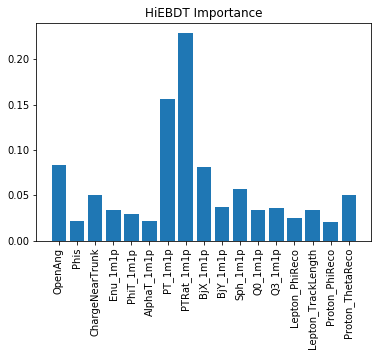

Accuracy Test:   0.9027502126453076
Accuracy Train:  0.9242265521335289
TestAcc - TrainAcc =  -2.147633948822125


In [13]:
X = df_signal[myvars].values.tolist()
Y_hiE = df_hiE[myvars].values.tolist()

#######################################################################################################
Xl = [1 for i in range(len(X))]
Yl = [0 for i in range(len(Y_hiE))]

seed = 15
test_size = 0.33
x_train, x_test, y_train, y_test = train_test_split(asarray(X+Y_hiE), asarray(Xl+Yl), test_size=test_size, random_state=seed)

eval_set = [(x_train, y_train), (x_test, y_test)]
hiEBDT = XGBClassifier(silent=False, 
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      #colsample_bytree = .8,
                      objective='binary:logistic',
                      subsample = 0.8, 
                      n_estimators=1000, 
                      max_depth=5, 
                      gamma=5)
hiEBDT.fit(x_train, y_train)

y_checkV = hiEBDT.predict(x_test) #
y_checkT = hiEBDT.predict(x_train) #
#
predictionsV = [round(value) for value in y_checkV] #
predictionsT = [round(value) for value in y_checkT] #
accuracy_diff = (accuracy_score(y_test, predictionsV)-accuracy_score(y_train,predictionsT))*100. #

fig,ax = plt.subplots(figsize=(6,4))
ax.set_title('HiEBDT Importance')
plt.bar(range(len(hiEBDT.feature_importances_)), hiEBDT.feature_importances_)
plt.xticks(range(len(hiEBDT.feature_importances_)),myvars, rotation='vertical')
plt.show()

acc_test = accuracy_score(y_test, predictionsV)
acc_train = accuracy_score(y_train,predictionsT)
accuracy_diff = (acc_test-acc_train)*100. #
print("Accuracy Test:  ",acc_test)
print("Accuracy Train: ",acc_train)
print("TestAcc - TrainAcc = ",accuracy_diff)


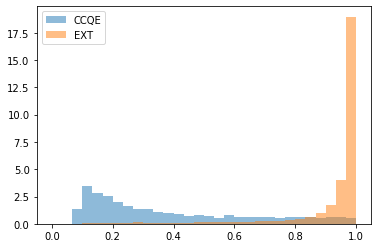

In [15]:
fig,ax = plt.subplots(figsize=(6,4))
bdt_score_ccqe = hiEBDT.predict_proba(X)
bdt_score_ext = hiEBDT.predict_proba(Y_hiE)

_ = plt.hist(bdt_score_ccqe[:,0],30,(0,1),alpha = .5,density=1,label='CCQE')
_ = plt.hist(bdt_score_ext[:,0],30,(0,1),alpha = .5,density=1,label='EXT')

plt.legend()

In [18]:
pickle.dump(hiEBDT,open( "../1mu1pSelection/bdtweight_1m1p_run1_hightrueE_may19.pickle", "wb" ),protocol=2)

# BDT Metrics

In [9]:
nbins = 45
s_annotation = 'All Precuts, Orthogonality Cuts'

#run1
df_numu_presel_r1 = pd.concat((df_numu_run1_presel,df_numu_run1_presel_lowe))
df_ccqe_r1 = df_numu_run1_presel.query("mc_label in ['numu_CCQE']")
df_ccqe_lowe_r1 = df_numu_run1_presel_lowe.query("mc_label in ['numu_CCQE']")

df_cosmic_r1 = pd.concat([df_ext_run1_presel,df_numu_presel_r1.query("mc_label in ['offvtx']")],sort=False)
df_nubkg_r1 = df_numu_presel_r1.query("mc_label not in ['numu_CCQE','nLmP','offvtx']")
df_nlmp_r1 = df_numu_presel_r1.query("mc_label in ['nLmP'] and int_label not in ['numu_CCQE']")


#run2
df_ccqe_r2 = df_numu_run2_presel.query("mc_label in ['numu_CCQE']")

df_cosmic_r2 = pd.concat([df_ext_run3_presel,df_numu_run2_presel.query("mc_label in ['offvtx']")],sort=False)
df_nubkg_r2 = df_numu_run2_presel.query("mc_label not in ['numu_CCQE','nLmP','offvtx']")
df_nlmp_r2 = df_numu_run2_presel.query("mc_label in ['nLmP'] and int_label not in ['numu_CCQE']")


#run3
df_numu_presel_r3 = pd.concat((df_numu_run3_presel,df_numu_run3_presel_lowe))
df_ccqe_r3 = df_numu_run3_presel.query("mc_label in ['numu_CCQE']")
df_ccqe_lowe_r3 = df_numu_run3_presel_lowe.query("mc_label in ['numu_CCQE']")

df_cosmic_r3 = pd.concat([df_ext_run3_presel,df_numu_presel_r3.query("mc_label in ['offvtx']")],sort=False)
df_nubkg_r3 = df_numu_presel_r3.query("mc_label not in ['numu_CCQE','nLmP','offvtx']")
df_nlmp_r3 = df_numu_presel_r3.query("mc_label in ['nLmP'] and int_label not in ['numu_CCQE']")

In [10]:
## run 1
X_r1 = pd.concat((df_ccqe_r1,df_ccqe_lowe_r1),sort=False)[myvars].values.tolist()
w1_r1 = np.ones(len(df_ccqe_r1))*1.0
w2_r1 = np.ones(len(df_ccqe_lowe_r1))*1
wsig_r1 = np.concatenate((w1_r1,w2_r1))

Y_bkg_r1 = pd.concat((df_cosmic_r1,df_nubkg_r1),sort=False)[myvars].values.tolist()
wbkg_r1 = np.ones(len(Y_bkg_r1))

Xl_r1 = [1 for i in range(len(X_r1))]
Yl_r1 = [0 for i in range(len(Y_bkg_r1))]

seed = 15
test_size = 0.7
x_train_r1, x_test_r1, y_train_r1, y_test_r1, w_train_r1, w_test_r1 = train_test_split(asarray(X_r1+Y_bkg_r1), asarray(Xl_r1+Yl_r1), np.concatenate((wsig_r1,wbkg_r1)), test_size=test_size, random_state=seed)


In [11]:
## same for run 2
X_r2 = df_ccqe_r2[myvars].values.tolist()
wsig_r2 = np.ones(len(df_ccqe_r2))*1

Y_bkg_r2 = pd.concat((df_cosmic_r2,df_nubkg_r2),sort=False)[myvars].values.tolist()
wbkg_r2 = np.ones(len(Y_bkg_r2))

Xl_r2 = [1 for i in range(len(X_r2))]
Yl_r2 = [0 for i in range(len(Y_bkg_r2))]

seed = 15
test_size = 0.7
x_train_r2, x_test_r2, y_train_r2, y_test_r2, w_train_r2, w_test_r2 = train_test_split(asarray(X_r2+Y_bkg_r2), asarray(Xl_r2+Yl_r2), np.concatenate((wsig_r2,wbkg_r2)), test_size=test_size, random_state=seed)

In [9]:
## same for run 3
X_r3 = pd.concat((df_ccqe_r3,df_ccqe_lowe_r3),sort=False)[myvars].values.tolist()
w1_r3 = np.ones(len(df_ccqe_r3))*1.0
w2_r3 = np.ones(len(df_ccqe_lowe_r3))*1
wsig_r3 = np.concatenate((w1_r3,w2_r3))

Y_bkg_r3 = pd.concat((df_cosmic_r3,df_nubkg_r3),sort=False)[myvars].values.tolist()
wbkg_r3 = np.ones(len(Y_bkg_r3))

Xl_r3 = [1 for i in range(len(X_r3))]
Yl_r3 = [0 for i in range(len(Y_bkg_r3))]

seed = 15
test_size = 0.7
x_train_r3, x_test_r3, y_train_r3, y_test_r3, w_train_r3, w_test_r3 = train_test_split(asarray(X_r3+Y_bkg_r3), asarray(Xl_r3+Yl_r3), np.concatenate((wsig_r3,wbkg_r3)), test_size=test_size, random_state=seed)

In [11]:
bkgBDT = XGBClassifier(silent=False, 
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      #colsample_bytree = .8,
                      objective='binary:logistic',
                      subsample = 0.8, 
                      n_estimators=1000, 
                      max_depth=5, 
                      gamma=5)




eval_metric = ['logloss','error']
quant='logloss'

eval_set = [(x_train_r2, y_train_r2), (x_test_r1, y_test_r1)]
bkgBDT.fit(x_train_r2, y_train_r2, sample_weight=w_train_r2,eval_metric=eval_metric, eval_set=eval_set,verbose=False)
y_testing_r1 = bkgBDT.evals_result()['validation_1'][quant]

eval_set = [(x_train_r2, y_train_r2), (x_test_r2, y_test_r2)]
bkgBDT.fit(x_train_r2, y_train_r2, sample_weight=w_train_r2,eval_metric=eval_metric, eval_set=eval_set,verbose=False)
y_training_r2 = bkgBDT.evals_result()['validation_0'][quant]
y_testing_r2 = bkgBDT.evals_result()['validation_1'][quant]

eval_set = [(x_train_r2, y_train_r2), (x_test_r3, y_test_r3)]
bkgBDT.fit(x_train_r2, y_train_r2, sample_weight=w_train_r2,eval_metric=eval_metric, eval_set=eval_set,verbose=False)
y_testing_r3 = bkgBDT.evals_result()['validation_1'][quant]

Text(0.5, 0, 'Number of Iterations')

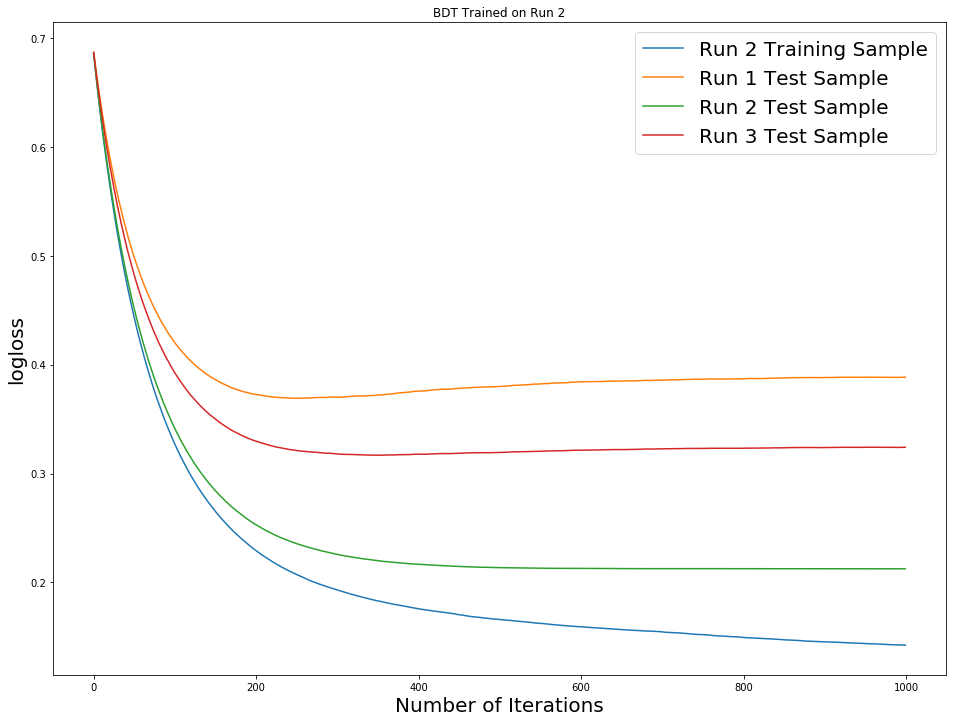

In [12]:
fig,ax = plt.subplots(figsize=(16,12))
plt.plot(range(len(y_training_r3)),y_training_r2,label='Run 2 Training Sample')
plt.plot(range(len(y_testing_r1)),y_testing_r1,label='Run 1 Test Sample')
plt.plot(range(len(y_testing_r2)),y_testing_r2,label='Run 2 Test Sample')
plt.plot(range(len(y_testing_r3)),y_testing_r3,label='Run 3 Test Sample')

ax.set_title('BDT Trained on Run 2')
ax.legend(fontsize=20)
ax.set_ylabel(quant,fontsize=20)
ax.set_xlabel('Number of Iterations',fontsize=20)

In [23]:
#Vary the seed.

bkgBDT = XGBClassifier(silent=False, 
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      #colsample_bytree = .8,
                      objective='binary:logistic',
                      subsample = 0.8, 
                      n_estimators=1000, 
                      max_depth=5, 
                      gamma=5)

eval_metric = ['logloss','error']
quant='logloss'

y_testing = []
y_training = []

for i in range(10):
    print('seed:',i)
    test_size = 0.3
    x_train_r1, x_test_r1, y_train_r1, y_test_r1, w_train_r1, w_test_r1 = train_test_split(asarray(X_r1+Y_bkg_r1), asarray(Xl_r1+Yl_r1), np.concatenate((wsig_r1,wbkg_r1)), test_size=test_size)
    
    eval_set = [(x_train_r1, y_train_r1), (x_test_r1, y_test_r1)]
    bkgBDT.fit(x_train_r1, y_train_r1, sample_weight=w_train_r1,eval_metric=eval_metric, eval_set=eval_set,verbose=False)
    y_testing.append(bkgBDT.evals_result()['validation_1'][quant])
    y_training.append(bkgBDT.evals_result()['validation_0'][quant])

seed: 0
seed: 1
seed: 2
seed: 3
seed: 4
seed: 5
seed: 6
seed: 7
seed: 8
seed: 9


Text(0.5, 0, 'Number of Iterations')

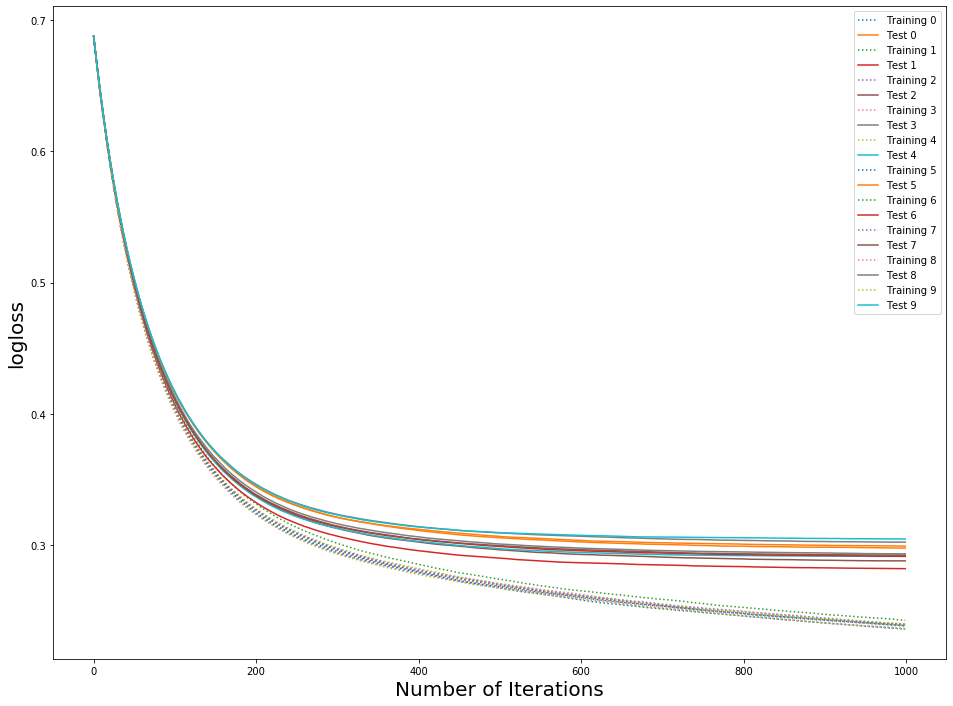

In [24]:
fig,ax = plt.subplots(figsize=(16,12))

for i in range(10):
    plt.plot(range(len(y_training[i])),y_training[i],label='Training %i'%i,linestyle=':')
    plt.plot(range(len(y_testing[i])),y_testing[i],label='Test %i'%i,linestyle='-')

ax.legend()
ax.set_ylabel(quant,fontsize=20)
ax.set_xlabel('Number of Iterations',fontsize=20)